In [1]:
#!/usr/bin/env python
# coding: utf-8

##### libraries
## 3rd party
from __future__ import print_function
import pywt
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'san-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
import copy
import pdb
import csv
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.set_default_tensor_type(torch.DoubleTensor)

# ignore package deprecation warnings
import warnings
warnings.filterwarnings("ignore")

## custom
from utils.data_formatting import HDF5Dataset
from utils.common import *

/home/john/venv_generic/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
##### parameters
val_fold = 4
bs = 32
b=12

In [3]:
dset_train = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=True,transform=DWT(4))
dset_val = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=False,transform=DWT(4))

dl_train = DataLoader(dset_train, batch_size=bs, shuffle=False, num_workers=0)
dl_val = DataLoader(dset_val, batch_size=bs, shuffle=False, num_workers=0)

In [4]:
##### main code
# load networks
model_path = f'snn_ref/model_fold{val_fold}.pt'
cnn = WVCNN4()
cnn.load_state_dict(torch.load(model_path).state_dict(), strict=False)
cnn_bninteg = WVCNN4()
cnn_bninteg.normed = True
cnn_bninteg.load_state_dict(cnn.state_dict())

<All keys matched successfully>

In [5]:
#"""
# import and format physionet data
data_raw = HDF5Dataset('../data/custom/physionet2017_4classes.hdf5', True)

# convert to slicable data
ecgs = torch.empty(len(data_raw),18000)
dwts = torch.empty(len(data_raw),2,1127)
lbls = torch.empty(len(data_raw))
for ii,data in enumerate(tqdm(data_raw)):
    if len(data[0][0]) >= 18000:
        data_in = data[0][:,0:18000]
    else:
        data_in = torch.zeros((1,18000))
        data_in[0,0:len(data[0][0])] = data[0]
    ecgs[ii,:] = data_in
    dwt_tmp = pywt.wavedec(data_in,'db2',level=4)
    dwts[ii,:,:] = torch.tensor(np.concatenate((dwt_tmp[0],dwt_tmp[1]),0))
    lbls[ii] = data[1]
#"""

100%|██████████| 8528/8528 [00:16<00:00, 512.54it/s]


In [6]:
#"""
# get train/test for normalization
fold_idx = split_into_5folds(lbls)
train_idx = (fold_idx!=val_fold)
val_idx = (fold_idx==val_fold)

dwt_val = dwts[val_idx].unsqueeze(1)
dwt_train = dwts[train_idx].unsqueeze(1)

lbl_val = lbls[val_idx].long()
lbl_train = lbls[train_idx].long()
#"""

In [7]:
# reference cnn
cnn.eval()
F1t_ref = eval_model(cnn, dl_train)

  1%|          | 2/214 [00:00<00:15, 13.52it/s]

tensor([[ 3.9823, -2.5904,  1.3450, -2.6394],
        [ 1.6625, -1.1305,  0.0781, -0.5590],
        [ 2.7647, -1.9413,  1.5864, -2.3459],
        [-1.0916,  2.4546,  1.2464, -2.4800],
        [-6.4831,  6.2422,  4.1548, -3.5330],
        [ 3.3940, -1.9636,  1.2760, -2.6138],
        [ 2.8489, -1.6963,  1.2443, -2.3048],
        [ 0.7253, -1.7211,  3.9823, -2.7965],
        [-1.6297,  2.6756,  1.2523, -2.2148],
        [ 3.4396, -2.1567,  1.3556, -2.5755],
        [ 3.1832, -2.4899,  0.7178, -1.3202],
        [ 1.8077, -0.5990,  0.9713, -2.0974],
        [ 0.7826, -0.6839,  2.6665, -2.6246],
        [ 2.1624, -1.9558,  0.5401, -0.6635],
        [-0.0517, -0.6707,  0.3256,  0.4001],
        [ 3.0525, -1.9447,  1.1915, -2.2090],
        [-0.9487,  0.5379,  1.4396, -0.9285],
        [ 3.7117, -2.6453,  1.4011, -2.3729],
        [ 3.9878, -2.5335,  1.8307, -3.1940],
        [ 0.4743, -0.0350,  2.2797, -2.5863],
        [ 3.5353, -2.2247,  1.5681, -2.7839],
        [ 0.1676, -1.4120, -0.4102

100%|██████████| 214/214 [00:14<00:00, 14.51it/s]

Total: 0.8193543553352356, N: 0.9157466292381287, AF: 0.7904191613197327, O: 0.7518972754478455, ACC: 0.8562005277044855


In [8]:
# reference including batchnormalization in weights and biases
cnn_bninteg.eval()
cnn_bninteg.update_weights_bn_integration()
F1t_trans1 = eval_model(cnn_bninteg, dl_train)

  1%|          | 2/214 [00:00<00:14, 14.48it/s]

tensor([[ 4.1285, -2.6979,  1.4046, -2.7350],
        [ 1.6965, -1.1737,  0.0738, -0.5448],
        [ 2.8017, -1.9906,  1.6724, -2.4167],
        [-1.2256,  2.6460,  1.3387, -2.6242],
        [-6.9312,  6.6343,  4.4496, -3.7523],
        [ 3.5037, -2.0247,  1.3318, -2.7151],
        [ 2.9243, -1.7413,  1.2975, -2.3855],
        [ 0.6537, -1.7793,  4.2351, -2.9101],
        [-1.7985,  2.8865,  1.3479, -2.3501],
        [ 3.5371, -2.2165,  1.4090, -2.6641],
        [ 3.2866, -2.6209,  0.7365, -1.3078],
        [ 1.8119, -0.5589,  1.0084, -2.1762],
        [ 0.7365, -0.6769,  2.8164, -2.7312],
        [ 2.2240, -2.0495,  0.5649, -0.6539],
        [-0.1134, -0.7156,  0.3655,  0.4659],
        [ 3.1472, -2.0157,  1.2431, -2.2816],
        [-1.0870,  0.6095,  1.5176, -0.9358],
        [ 3.8247, -2.7628,  1.4768, -2.4421],
        [ 4.1131, -2.6183,  1.9171, -3.3181],
        [ 0.4018,  0.0250,  2.4162, -2.7055],
        [ 3.6430, -2.3017,  1.6427, -2.8863],
        [ 0.1385, -1.5487, -0.4438

100%|██████████| 214/214 [00:15<00:00, 14.09it/s]

Total: 0.8192494511604309, N: 0.9170172810554504, AF: 0.7866894006729126, O: 0.7540415525436401, ACC: 0.8569334506009968


In [10]:
# save BN integrated model for other conversion methodologies
model_path_bnintegr = f'comp_sota_cnn2snn/model_fold{val_fold}_bnintegr.pt'
torch.save(cnn_bninteg, model_path_bnintegr)

In [11]:
# normed model such that input and activations are in [0,1]
cnn_normed = WVCNN4()
cnn_normed.load_state_dict(cnn_bninteg.state_dict())

<All keys matched successfully>

In [12]:
cnn_normed.calculate_norm_values(dwt_train)
cnn_normed.print_norm_values()
cnn_normed.update_weights_with_norm_values()

input: lmbda=0.015740190112859882,dlta=0.4815042797031844
conv1: lmbda=0.06884055279420398,dlta=0
conv2: lmbda=0.030128361216034467,dlta=0
conv3: lmbda=0.10911830024841578,dlta=0
conv4: lmbda=0.01113663368339873,dlta=0
fc: lmbda=0.03500711123536534,dlta=0


In [13]:
# prepare dataloader with normalization of input
dsetn_train = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=True,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=False))
dsetn_val = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=False,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=False))

dln_train = DataLoader(dsetn_train, batch_size=bs, shuffle=False, num_workers=0)
dln_val = DataLoader(dsetn_val, batch_size=bs, shuffle=False, num_workers=0)

In [14]:
cnn_normed.eval()
F1t_trans2 = eval_model(cnn_normed, dln_train)

  2%|▏         | 4/214 [00:00<00:13, 15.40it/s]

tensor([[ 0.1445, -0.0944,  0.0492, -0.0957],
        [ 0.0594, -0.0411,  0.0026, -0.0191],
        [ 0.0981, -0.0697,  0.0585, -0.0846],
        [-0.0429,  0.0926,  0.0469, -0.0919],
        [-0.2426,  0.2322,  0.1558, -0.1314],
        [ 0.1227, -0.0709,  0.0466, -0.0950],
        [ 0.1024, -0.0610,  0.0454, -0.0835],
        [ 0.0229, -0.0623,  0.1483, -0.1019],
        [-0.0630,  0.1010,  0.0472, -0.0823],
        [ 0.1238, -0.0776,  0.0493, -0.0933],
        [ 0.1151, -0.0917,  0.0258, -0.0458],
        [ 0.0634, -0.0196,  0.0353, -0.0762],
        [ 0.0258, -0.0237,  0.0986, -0.0956],
        [ 0.0779, -0.0717,  0.0198, -0.0229],
        [-0.0040, -0.0251,  0.0128,  0.0163],
        [ 0.1102, -0.0706,  0.0435, -0.0799],
        [-0.0381,  0.0213,  0.0531, -0.0328],
        [ 0.1339, -0.0967,  0.0517, -0.0855],
        [ 0.1440, -0.0917,  0.0671, -0.1162],
        [ 0.0141,  0.0009,  0.0846, -0.0947],
        [ 0.1275, -0.0806,  0.0575, -0.1010],
        [ 0.0048, -0.0542, -0.0155

100%|██████████| 214/214 [00:14<00:00, 14.38it/s]

Total: 0.8192494511604309, N: 0.9170172810554504, AF: 0.7866894006729126, O: 0.7540415525436401, ACC: 0.8569334506009968


In [15]:
# plot weight & bias distribution as preparation for quantization
# plt.figure(0,figsize=[25,5])
# ax1 = plt.subplot(1, 5, 1)
# plt.hist(cnn_normed.conv1.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 2)
# plt.hist(cnn_normed.conv2.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 3)
# plt.hist(cnn_normed.conv3.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 4)
# plt.hist(cnn_normed.conv4.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 5)
# plt.hist(cnn_normed.fc.weight.flatten(),range=(-5,5),bins=20);

In [16]:
# plt.figure(0,figsize=[25,5])
# ax1 = plt.subplot(1, 5, 1)
# plt.hist(cnn_normed.conv1.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 2)
# plt.hist(cnn_normed.conv2.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 3)
# plt.hist(cnn_normed.conv3.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 4)
# plt.hist(cnn_normed.conv4.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 5)
# plt.hist(cnn_normed.fc.bias.flatten(),range=(-5,5),bins=20);

In [17]:
# NN in fixed point only
#b=16

cnn_quant = WVCNN4()
cnn_quant.load_state_dict(cnn_normed.state_dict())
#cnn_quant = cnn_normed
cnn_quant.update_weights_with_quant(b=b) # number of fractional bits for weights and bias
cnn_quant.q_actb = b # number of fractional bits for activations
cnn_quant.quantize = True
cnn_quant.normed = True

In [18]:
cnn_quant.eval()
eval_model(cnn_quant, dln_train)

  1%|          | 2/214 [00:00<00:16, 12.74it/s]

tensor([[ 0.1426, -0.0930,  0.0476, -0.0935],
        [ 0.0593, -0.0420,  0.0017, -0.0171],
        [ 0.0947, -0.0652,  0.0542, -0.0813],
        [-0.0405,  0.0913,  0.0449, -0.0911],
        [-0.2417,  0.2332,  0.1548, -0.1318],
        [ 0.1189, -0.0681,  0.0459, -0.0933],
        [ 0.1013, -0.0598,  0.0454, -0.0833],
        [ 0.0217, -0.0586,  0.1426, -0.0986],
        [-0.0630,  0.1016,  0.0437, -0.0793],
        [ 0.1218, -0.0754,  0.0474, -0.0913],
        [ 0.1145, -0.0923,  0.0234, -0.0422],
        [ 0.0569, -0.0134,  0.0347, -0.0750],
        [ 0.0244, -0.0208,  0.0955, -0.0940],
        [ 0.0767, -0.0706,  0.0176, -0.0208],
        [-0.0032, -0.0244,  0.0103,  0.0176],
        [ 0.1091, -0.0691,  0.0430, -0.0793],
        [-0.0413,  0.0234,  0.0503, -0.0288],
        [ 0.1304, -0.0925,  0.0454, -0.0801],
        [ 0.1411, -0.0872,  0.0630, -0.1135],
        [ 0.0105,  0.0049,  0.0828, -0.0933],
        [ 0.1233, -0.0776,  0.0552, -0.0974],
        [ 0.0017, -0.0525, -0.0151

100%|██████████| 214/214 [00:15<00:00, 13.69it/s]

Total: 0.8155252933502197, N: 0.9182551503181458, AF: 0.7796327471733093, O: 0.7486880421638489, ACC: 0.8557607739665787


(tensor(0.8155, dtype=torch.float32),
 tensor(0.9183, dtype=torch.float32),
 tensor(0.7796, dtype=torch.float32),
 tensor(0.7487, dtype=torch.float32),
 tensor([0, 0, 0,  ..., 2, 0, 0]))

In [19]:
cnn_quant.saturate = True
cnn_quant.eval()
F1t_trans3 = eval_model(cnn_quant, dln_train)

  1%|          | 2/214 [00:00<00:15, 13.30it/s]

tensor([[ 0.1426, -0.0930,  0.0476, -0.0935],
        [ 0.0593, -0.0420,  0.0017, -0.0171],
        [ 0.0947, -0.0652,  0.0542, -0.0813],
        [-0.0405,  0.0913,  0.0449, -0.0911],
        [-0.2417,  0.2332,  0.1548, -0.1318],
        [ 0.1189, -0.0681,  0.0459, -0.0933],
        [ 0.1013, -0.0598,  0.0454, -0.0833],
        [ 0.0217, -0.0586,  0.1426, -0.0986],
        [-0.0630,  0.1016,  0.0437, -0.0793],
        [ 0.1218, -0.0754,  0.0474, -0.0913],
        [ 0.1145, -0.0923,  0.0234, -0.0422],
        [ 0.0569, -0.0134,  0.0347, -0.0750],
        [ 0.0244, -0.0208,  0.0955, -0.0940],
        [ 0.0767, -0.0706,  0.0176, -0.0208],
        [-0.0032, -0.0244,  0.0103,  0.0176],
        [ 0.1091, -0.0691,  0.0430, -0.0793],
        [-0.0413,  0.0234,  0.0503, -0.0288],
        [ 0.1304, -0.0925,  0.0454, -0.0801],
        [ 0.1411, -0.0872,  0.0630, -0.1135],
        [ 0.0105,  0.0049,  0.0828, -0.0933],
        [ 0.1233, -0.0776,  0.0552, -0.0974],
        [ 0.0017, -0.0525, -0.0151

100%|██████████| 214/214 [00:15<00:00, 13.59it/s]

Total: 0.8155252933502197, N: 0.9182551503181458, AF: 0.7796327471733093, O: 0.7486880421638489, ACC: 0.8557607739665787


In [20]:
# prepare transformation of input data such that DWT calculation is in fixed point
#b=16

dsetnq_train = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=True,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=True,b=b))
dsetnq_val = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=False,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=True,b=b))

dlnq_train = DataLoader(dsetnq_train, batch_size=bs, shuffle=False, num_workers=0)
dlnq_val = DataLoader(dsetnq_val, batch_size=bs, shuffle=False, num_workers=0)

cnn_quant = WVCNN4()
cnn_quant.load_state_dict(cnn_normed.state_dict())
#cnn_quant = cnn_normed
cnn_quant.update_weights_with_quant(b=b) # number of fractional bits for weights and bias
cnn_quant.q_actb = b # number of fractional bits for activations
cnn_quant.quantize = True
cnn_quant.normed = True
cnn_quant.saturate = True
cnn_quant.eval()
F1t_trans4 = eval_model(cnn_quant, dlnq_train)

  1%|          | 2/214 [00:00<00:18, 11.30it/s]

tensor([[ 0.1426, -0.0933,  0.0476, -0.0933],
        [ 0.0593, -0.0417,  0.0020, -0.0173],
        [ 0.0940, -0.0649,  0.0549, -0.0813],
        [-0.0398,  0.0901,  0.0449, -0.0906],
        [-0.2432,  0.2344,  0.1555, -0.1326],
        [ 0.1187, -0.0684,  0.0454, -0.0923],
        [ 0.1006, -0.0593,  0.0454, -0.0830],
        [ 0.0225, -0.0593,  0.1431, -0.0991],
        [-0.0632,  0.1018,  0.0435, -0.0791],
        [ 0.1213, -0.0762,  0.0479, -0.0906],
        [ 0.1147, -0.0928,  0.0234, -0.0422],
        [ 0.0579, -0.0144,  0.0347, -0.0750],
        [ 0.0229, -0.0203,  0.0967, -0.0942],
        [ 0.0769, -0.0703,  0.0176, -0.0210],
        [-0.0034, -0.0242,  0.0100,  0.0178],
        [ 0.1089, -0.0691,  0.0432, -0.0796],
        [-0.0410,  0.0232,  0.0505, -0.0291],
        [ 0.1316, -0.0938,  0.0457, -0.0798],
        [ 0.1411, -0.0876,  0.0647, -0.1145],
        [ 0.0105,  0.0046,  0.0825, -0.0928],
        [ 0.1233, -0.0774,  0.0552, -0.0974],
        [ 0.0017, -0.0532, -0.0156

100%|██████████| 214/214 [00:19<00:00, 10.90it/s]

Total: 0.8170279860496521, N: 0.918546199798584, AF: 0.7823185920715332, O: 0.7502191066741943, ACC: 0.8566402814423922


In [21]:
# Save final model 
model_path_snn = f'snn_ref/model_fold{val_fold}_snn.pt'
torch.save(cnn_quant, model_path_snn)

In [22]:
# For matlab
import scipy.io as sio
export_dict = {}
sd = cnn_quant.state_dict()
for entry in sd:
    export_dict[entry.replace(".","_")] = sd[entry].numpy()

export_dict['input_lmbda'] = cnn_normed.input_lmbda.numpy()
export_dict['input_dlta'] = cnn_normed.input_dlta.numpy()
    
sio.savemat(f'model_state_dict{val_fold}_snn.mat', {'dict': export_dict})

In [23]:
# get metrics for evaluation on train set (see above)
#F1t_ref = eval_model(cnn, dl_train,print_first=False)
#F1t_trans1 = eval_model(cnn_bninteg, dl_train,print_first=False)
#F1t_trans2 = eval_model(cnn_normed, dln_train,print_first=False)
#F1t_trans3 = eval_model(cnn_quant, dln_train,print_first=False)

# get metrics for evaluation on validation set
F1v_ref = eval_model(cnn, dl_val,print_first=False)
F1v_trans1 = eval_model(cnn_bninteg, dl_val,print_first=False)
F1v_trans2 = eval_model(cnn_normed, dln_val,print_first=False)
F1v_trans3 = eval_model(cnn_quant, dln_val,print_first=False)
F1v_trans4 = eval_model(cnn_quant, dlnq_val,print_first=False)

100%|██████████| 54/54 [00:03<00:00, 13.98it/s]


Total: 0.8070570826530457, N: 0.8963474631309509, AF: 0.8057971000671387, O: 0.7190265655517578, ACC: 0.8311840562719812


100%|██████████| 54/54 [00:03<00:00, 14.76it/s]


Total: 0.8081307411193848, N: 0.8977159857749939, AF: 0.8057971000671387, O: 0.7208791375160217, ACC: 0.8311840562719812


100%|██████████| 54/54 [00:03<00:00, 13.79it/s]


Total: 0.8081307411193848, N: 0.8977159857749939, AF: 0.8057971000671387, O: 0.7208791375160217, ACC: 0.8311840562719812


100%|██████████| 54/54 [00:04<00:00, 13.04it/s]


Total: 0.799759566783905, N: 0.89682537317276, AF: 0.7955182194709778, O: 0.7069351077079773, ACC: 0.8259085580304807


100%|██████████| 54/54 [00:05<00:00, 10.63it/s]

Total: 0.8024044036865234, N: 0.8977159857749939, AF: 0.7988826632499695, O: 0.7106145024299622, ACC: 0.8276670574443142


findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: 

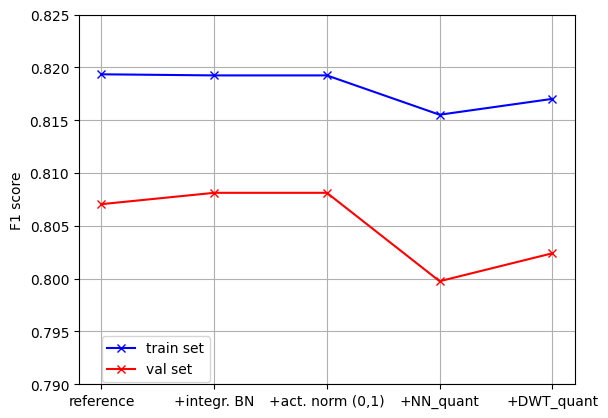

In [24]:
# plot data
train_all = [F1t_ref[0],F1t_trans1[0],F1t_trans2[0],F1t_trans3[0],F1t_trans4[0]]
val_all = [F1v_ref[0],F1v_trans1[0],F1v_trans2[0],F1v_trans3[0],F1v_trans4[0]]
trans_descr = ["reference","+integr. BN","+act. norm (0,1)","+NN_quant","+DWT_quant"]

# plot metrics
ax = plt.figure(0)
plt.plot(trans_descr,train_all,"b-x", label='train set')
plt.plot(trans_descr,val_all,"r-x", label='val set')
plt.grid(True,which='both')
plt.ylim((0.790,0.825))
#plt.ylabel("F1 score (CinC'17 definition)")
plt.ylabel("F1 score")
#plt.title(f"Normalization & Quantization of WVCNN design for SNN conversion\n (b={b} fractional bits)")
ax.legend(loc='lower left', bbox_to_anchor=(0.15, 0.1))
plt.savefig('wvcnn_norm_steps.png',dpi=600)
plt.savefig('wvcnn_norm_steps.pdf')

In [25]:
# Difference of classified samples between reference and "final" quantized version
print(len(F1t_ref[4]))
print((F1t_ref[4] != F1t_trans3[4]).sum())
print((F1t_ref[4] != F1t_trans4[4]).sum())

6822
tensor(93)
tensor(96)


In [26]:
# Output of quantized version in pytorch (!! NOT EQUAL to Matlab version due to rounding scheme !!)
# roundig scheme should be fixed via custom round_halfup
dwt_in = dwts[2].unsqueeze(0).unsqueeze(0) * cnn_normed.input_lmbda + cnn_normed.input_dlta
res = cnn_quant(dwt_in)
res
#dwts[2]

tensor([[ 0.0947, -0.0652,  0.0542, -0.0813]])

findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: Font family 'san-serif' not found.
findfont: 

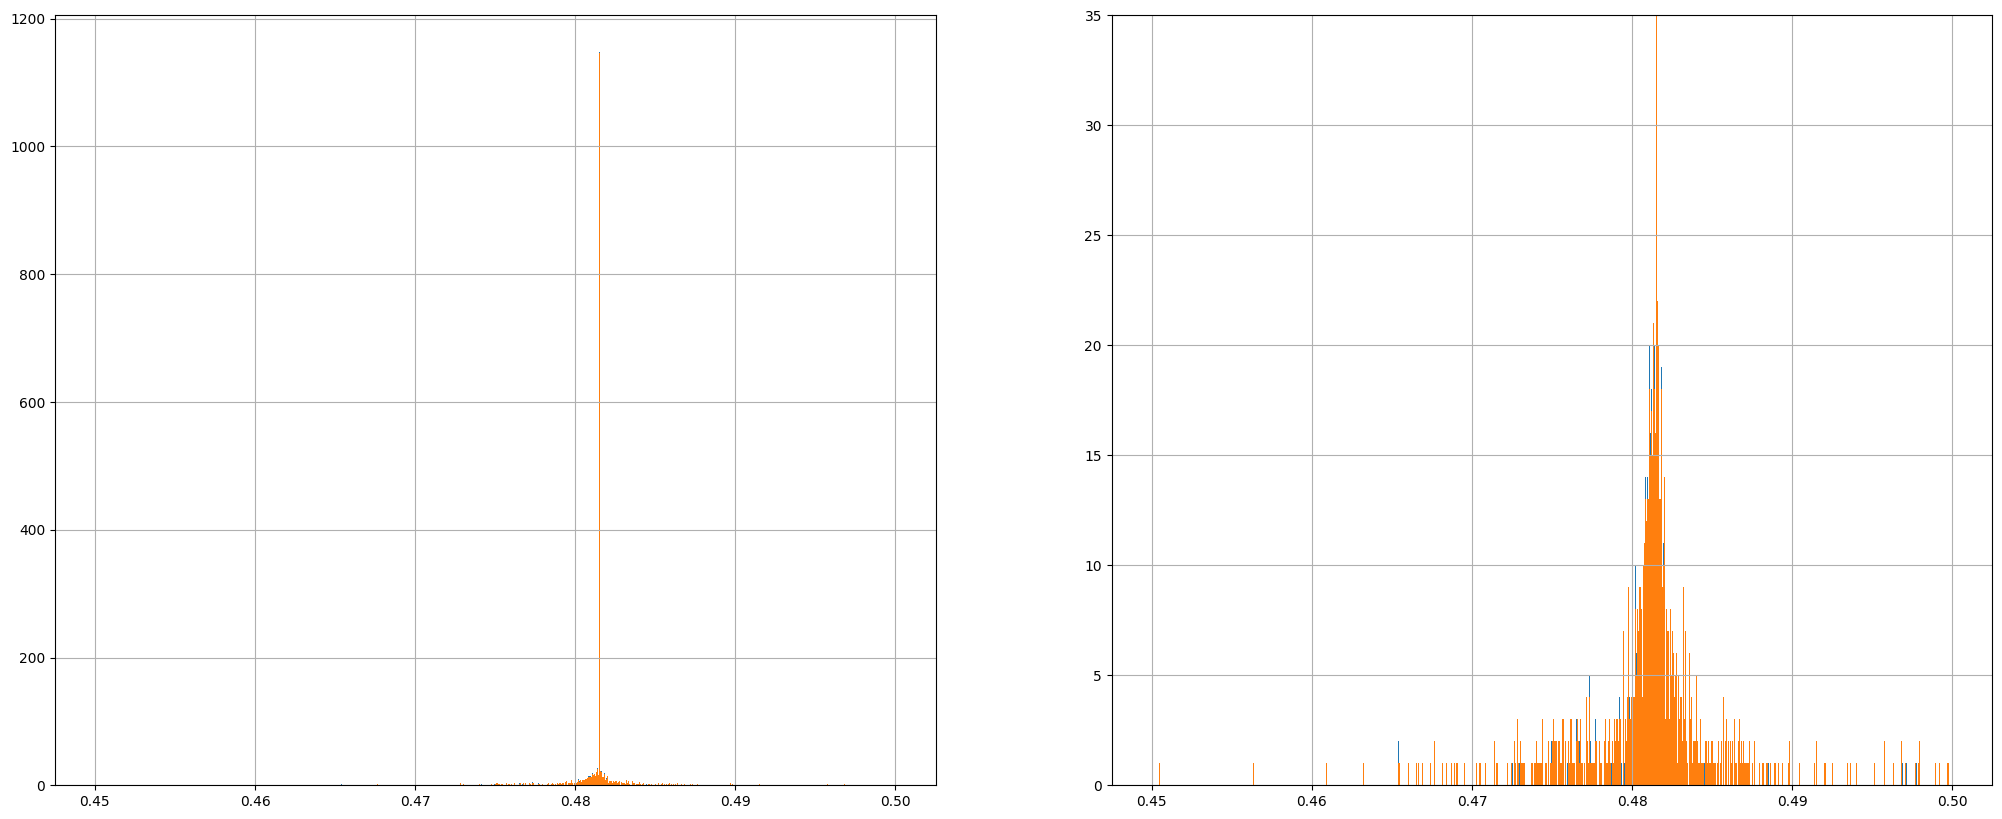

In [27]:
d = next(iter(dln_train))
dq = next(iter(dlnq_train))

# rough distribution of fixed-point DWT (weights and activations of filter quantized in each stage -> 4 stages) and floating-point DWT
# one batch
plt.figure(0,figsize=[25,10])
ax1 = plt.subplot(1, 2, 1)
plt.hist(d['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
plt.hist(dq['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
plt.grid()

ax2 = plt.subplot(1, 2, 2)
plt.hist(d['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
plt.hist(dq['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
plt.ylim([0, 35])
plt.grid()

In [28]:
def q(x,b):
    # no saturation!
    result = torch.round(x * 2**b) / 2**b
    return result 

db2wvlt = pywt.Wavelet('db2')
# floating point values in python are stored as double precision values
print(type(db2wvlt.dec_lo[0]))


dlo_fp64 = np.array(db2wvlt.dec_lo,dtype=np.float64)
dlo_fp64 = torch.from_numpy(dlo_fp64)
dhi_fp64 = np.array(db2wvlt.dec_hi,dtype=np.float64)
dhi_fp64 = torch.from_numpy(dhi_fp64)
print(dlo_fp64.dtype)
print(dlo_fp64)
print(dhi_fp64)
dlo = q(dlo_fp64,b)
dhi = q(dhi_fp64,b)
print(dlo.dtype)
print(dlo)
print(dhi)

edlo_abs = torch.abs(dlo-dlo_fp64)
edlo_rmse = torch.sqrt(torch.mean(edlo_abs**2))
edhi_abs = torch.abs(dhi-dhi_fp64)
edhi_rmse = torch.sqrt(torch.mean(edhi_abs**2))
print(f'Lowpass Coefficient RMSE due to quantization: {edlo_rmse}')
print(f'Highpass Coefficient RMSE due to quantization: {edhi_rmse}')
torch.zeros((1,18000)).dtype

<class 'float'>
torch.float64
tensor([-0.1294,  0.2241,  0.8365,  0.4830])
tensor([-0.4830,  0.8365, -0.2241, -0.1294])
torch.float64
tensor([-0.1294,  0.2241,  0.8364,  0.4829])
tensor([-0.4829,  0.8364, -0.2241, -0.1294])
Lowpass Coefficient RMSE due to quantization: 5.4131825689739665e-05
Highpass Coefficient RMSE due to quantization: 5.4131825689739665e-05


torch.float64

In [29]:
# Test rounding fcn
import math
x = -0.5

def round_halfup(x):
    return math.ceil(math.floor(2*x)/2)

test = round_halfup(x)
test

0